In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import confusion_matrix
from importlib import reload

from src.utils import calculate_profit, train_val_test_split, signed_log10_1p
from src import plot_utils
from src import features

In [2]:
%config Completer.use_jedi = False

## Construct the `profit`, `log_profit` and `profitable` variables

In [3]:
funnel = pd.read_csv('train_data/funnel.csv')
funnel['profit'] = calculate_profit(funnel)
funnel['profitable'] = (funnel['profit'] > 0).astype(int)
funnel['log_profit'] = funnel['profit'].apply(signed_log10_1p)
funnel["sale_amount"].fillna(0, inplace=True)

train_funnel, val_funnel, test_funnel = train_val_test_split(funnel, (0.8, 0.1, 0.1))

<AxesSubplot:>

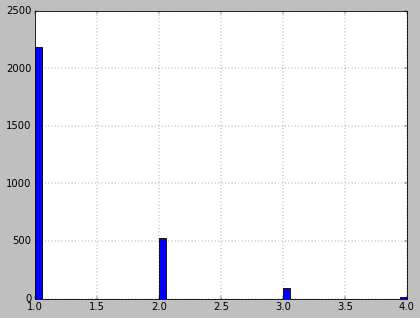

In [4]:
mask = train_funnel['sale_flg'] == 1
train_funnel[mask]['contacts'].hist(bins=51)

<AxesSubplot:>

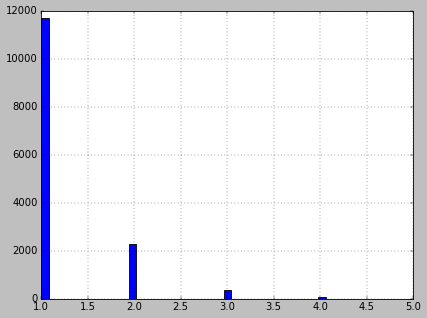

In [5]:
train_funnel[~mask]['contacts'].hist(bins=51)

## Mystery features: 1 and 9 might be categorical

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

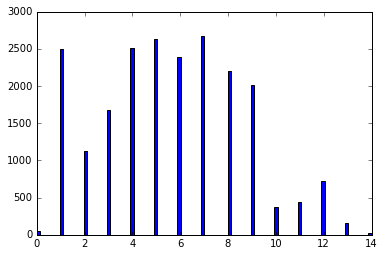

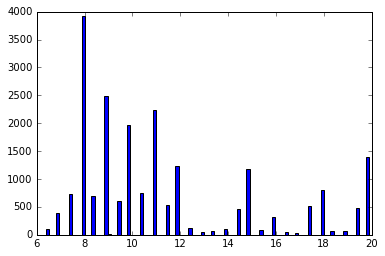

In [7]:
for i in [1, 9]:
    plt.hist(funnel[f'feature_{i}'], bins=100);
    plt.show()


## Compute all features

In [14]:
LABEL_COLS = ['sale_flg', 'sale_amount', 'contacts', 'profit', 'profitable', 'log_profit']
CAT_FEATURES = ['gender', 'region', 'city', 'education', 'mcc_cd', 'feature_1'] # , 'feature_9'

In [15]:
reload(features)

<module 'src.features' from '/home/marina/Documents/IDAO/squatting-slavs-strike-back/src/features.py'>

In [16]:
data_dir = 'train_data'
all_ft = []
group_to_cols = dict()

for nm, extr in [
    ('balance',  features.BalanceFtExtractor(fn=f'{data_dir}/balance.csv')),
    ('aum',      features.AUMFtExtractor(fn=f'{data_dir}/aum.csv')),
    ('client',   features.ClientFtExtractor(fn=f'{data_dir}/client.csv')),
    ('trxn',     features.TrxnFtExtractor(fn=f'{data_dir}/trxn.csv')),
    ('payments', features.PaymentFtExtractor(fn=f'{data_dir}/payments.csv')),
    ('mystery',  features.MysteryFtExtractor(fn=f'{data_dir}/funnel.csv')),
    ('campaign', features.CampaignFtExtractor(fn=f'{data_dir}/com.csv')),
]:
    ft = extr.load_transform()
    group_to_cols[nm] = list(ft.columns)
    ft = ft.reset_index()
    # for payments fts
    if 'index' in ft.columns:
        ft.rename(columns={'index': 'client_id'}, inplace=True)
    ft = pd.merge(funnel[['client_id']], ft, how='left', on='client_id').set_index('client_id')
    all_ft.append(ft)
    
labels_all = funnel.set_index('client_id')[LABEL_COLS]
full_data = pd.concat([labels_all] + all_ft, axis=1)

full_data = full_data.fillna({'mcc_cd': 'nan'})

In [17]:
full_data.shape

(21498, 81)

In [12]:
cat_ft

['region', 'feature_1', 'gender', 'mcc_cd', 'education', 'city']

# Contacts model

In [19]:
train, val, test = train_val_test_split(full_data, [0.8, 0.1, 0.1])

# input for contacts model
label_col = 'contacts'
ft_cols = group_to_cols['client'] + group_to_cols['campaign']
cat_ft = list(set(CAT_FEATURES).intersection(set(ft_cols)))

contacts_train_pool = Pool(
    data = train[ft_cols],
    label = train[label_col],
    cat_features=cat_ft
)
contacts_val_pool = Pool(
    data = val[ft_cols], 
    label = val[label_col],
    cat_features=cat_ft
)
contacts_test_pool = Pool(
    data = test[ft_cols], 
    cat_features=cat_ft
)

In [20]:
contacts_model = CatBoostRegressor(
    iterations=1500,
    depth=10,
#     l2
    loss_function='RMSE',
#     eval_metric=ProfitMetric,
    use_best_model=True,
)

In [22]:
contacts_model.fit(contacts_train_pool, eval_set=contacts_val_pool, verbose=100)

Learning rate set to 0.061276
0:	learn: 0.5016677	test: 0.5010435	best: 0.5010435 (0)	total: 69.5ms	remaining: 1m 44s
100:	learn: 0.4785785	test: 0.4969860	best: 0.4966630 (47)	total: 1.4s	remaining: 19.4s
200:	learn: 0.4642596	test: 0.4977188	best: 0.4966630 (47)	total: 2.86s	remaining: 18.5s
300:	learn: 0.4502540	test: 0.4977543	best: 0.4966630 (47)	total: 4.45s	remaining: 17.7s
400:	learn: 0.4368525	test: 0.4986227	best: 0.4966630 (47)	total: 6.24s	remaining: 17.1s
500:	learn: 0.4255447	test: 0.4988312	best: 0.4966630 (47)	total: 7.96s	remaining: 15.9s
600:	learn: 0.4146999	test: 0.4996635	best: 0.4966630 (47)	total: 9.64s	remaining: 14.4s
700:	learn: 0.4050247	test: 0.5004565	best: 0.4966630 (47)	total: 11.4s	remaining: 13s
800:	learn: 0.3948638	test: 0.5012087	best: 0.4966630 (47)	total: 13.1s	remaining: 11.4s
900:	learn: 0.3852100	test: 0.5020833	best: 0.4966630 (47)	total: 15.1s	remaining: 10s
1000:	learn: 0.3750001	test: 0.5025270	best: 0.4966630 (47)	total: 17s	remaining: 8.45

# Amount model

In [109]:
for tmp_df in [train, val, test]:
    tmp_df['log_sale'] = np.log10(1 + tmp_df['sale_amount'])


In [110]:
# input for sale_amount model
label_col = 'log_sale'
ft_cols = group_to_cols['balance']\
        + group_to_cols['aum']\
        + group_to_cols['client']\
        + group_to_cols['trxn']\
        + group_to_cols['payments']\
        + group_to_cols['mystery']

cat_ft = list(set(CAT_FEATURES).intersection(set(ft_cols)))

amount_train_pool = Pool(
    data = train[ft_cols],
    label = train[label_col],
    cat_features=cat_ft
)
amount_val_pool = Pool(
    data = val[ft_cols], 
    label = val[label_col],
    cat_features=cat_ft
)
amount_test_pool = Pool(
    data = test[ft_cols], 
    cat_features=cat_ft
)

In [111]:
amount_model = CatBoostRegressor(
    iterations=400,
    depth=10,
    loss_function='RMSE',
    use_best_model=True,
)

In [112]:
amount_model.fit(amount_train_pool, eval_set=amount_val_pool, verbose=100)

Learning rate set to 0.139608
0:	learn: 1.5921596	test: 1.6110561	best: 1.6110561 (0)	total: 76.7ms	remaining: 30.6s
100:	learn: 0.9446804	test: 1.2589051	best: 1.2572863 (79)	total: 7.09s	remaining: 21s
200:	learn: 0.7176370	test: 1.2595561	best: 1.2566195 (137)	total: 13.8s	remaining: 13.7s
300:	learn: 0.5820399	test: 1.2704593	best: 1.2566195 (137)	total: 21s	remaining: 6.91s
399:	learn: 0.4846823	test: 1.2740479	best: 1.2566195 (137)	total: 27.6s	remaining: 0us

bestTest = 1.256619481
bestIteration = 137

Shrink model to first 138 iterations.


# Sum model

In [232]:
# input for sale_amount model
label_col = 'log_profit'
ft_cols = group_to_cols['balance']\
        + group_to_cols['aum']\
        + group_to_cols['client']\
        + group_to_cols['trxn']\
        + group_to_cols['payments']\
        + group_to_cols['mystery']\
#         + group_to_cols['campaign']

cat_ft = list(set(CAT_FEATURES).intersection(set(ft_cols)))

profit_train_pool = Pool(
    data = train[ft_cols],
    label = train[label_col],
    cat_features=cat_ft
)
profit_val_pool = Pool(
    data = val[ft_cols], 
    label = val[label_col],
    cat_features=cat_ft
)
profit_test_pool = Pool(
    data = test[ft_cols], 
    cat_features=cat_ft
)

In [233]:
CAT_FEATURES

['gender', 'region', 'city', 'education', 'mcc_cd', 'feature_1']

(array([1.5133e+04, 1.1260e+03, 4.8000e+02, 2.3600e+02, 1.0700e+02,
        6.4000e+01, 3.8000e+01, 7.0000e+00, 2.0000e+00, 5.0000e+00]),
 array([-20000.   ,  11953.075,  43906.15 ,  75859.225, 107812.3  ,
        139765.375, 171718.45 , 203671.525, 235624.6  , 267577.675,
        299530.75 ]),
 <BarContainer object of 10 artists>)

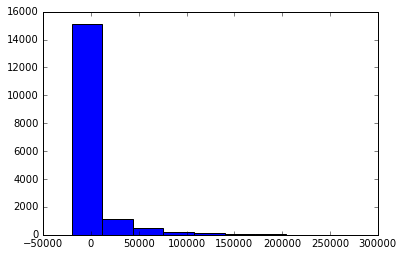

In [276]:
plt.hist(train['profit'])

In [270]:
profit_model = CatBoostRegressor(
    iterations=500,
    depth=10,
    one_hot_max_size=4,
#     l2
    loss_function='MAE',
#     eval_metric=ProfitMetric,
    use_best_model=True,
)

In [271]:
profit_model.fit(profit_train_pool, eval_set=profit_val_pool, verbose=100)

0:	learn: 1.2856154	test: 1.3196590	best: 1.3196590 (0)	total: 62.8ms	remaining: 31.3s
100:	learn: 0.9987256	test: 1.1610031	best: 1.1608851 (98)	total: 5.48s	remaining: 21.7s
200:	learn: 0.8813920	test: 1.1536687	best: 1.1502213 (164)	total: 10.9s	remaining: 16.2s
300:	learn: 0.8079144	test: 1.1578150	best: 1.1502213 (164)	total: 16.2s	remaining: 10.7s
400:	learn: 0.7552515	test: 1.1601558	best: 1.1502213 (164)	total: 21.7s	remaining: 5.36s
499:	learn: 0.7028658	test: 1.1683194	best: 1.1502213 (164)	total: 28s	remaining: 0us

bestTest = 1.150221298
bestIteration = 164

Shrink model to first 165 iterations.


In [272]:
profit_n = profit_model.predict(profit_test_pool)
loss_k = np.array([
    calculate_profit(test)[(profit_n > x).astype(bool)].sum() 
    for x in np.linspace(-4, 2, 20)
]) / 1e6

In [273]:
loss_k.max()

10.624138100000001

In [269]:
loss_k.max()

11.15133505

# new model

In [225]:
contacts_n = contacts_model.predict(contacts_train_pool)
amount_n = amount_model.predict(amount_train_pool)



In [226]:
train['log_profit'].values

array([-3.90314427, -3.60216855, -3.60216855, ..., -4.07921744,
        4.20449982,  5.18213507])

In [227]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [228]:
clf = LinearRegression()

In [229]:
X_n2 = np.stack((contacts_n, 10**amount_n)).T

In [230]:
clf.fit(X_n2, train['profit'])

LinearRegression()

/home/marina/Documents/IDAO/squatting-slavs-strike-back/src/plot_utils.py:91: RuntimeWarning: invalid value encountered in true_divide
  y_std_T /= np.sqrt(scipy.stats.binned_statistic(x_t, y_t, statistic="count", bins=n_bins)[0])


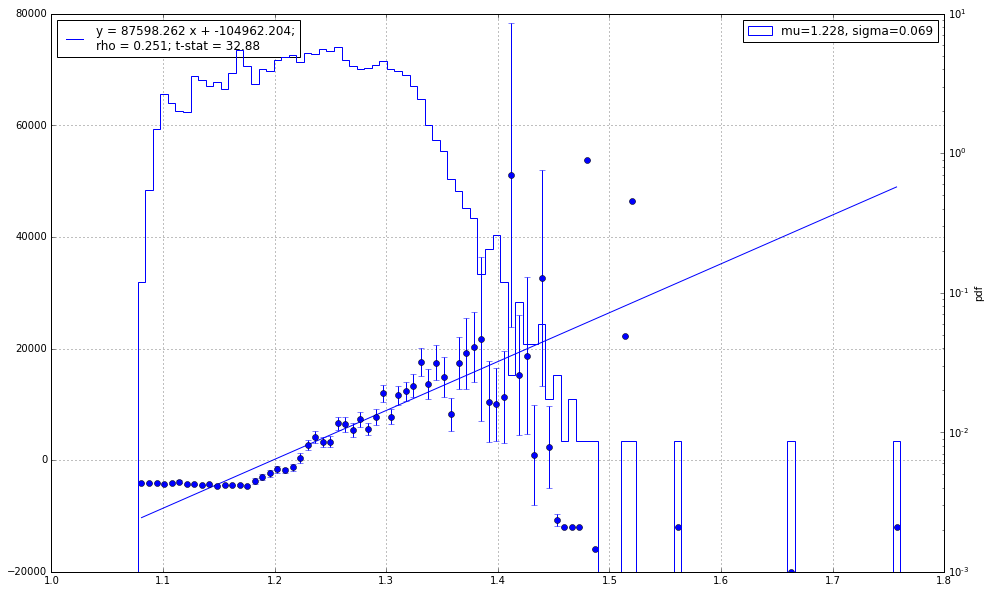

In [231]:
plot_utils.binned_plot(contacts_n, train['profit'])

# Compare

In [191]:
contacts_n = contacts_model.predict(contacts_test_pool)

In [192]:
amount_n = amount_model.predict(amount_test_pool)

In [195]:
X_n2 = np.stack((contacts_n, 10**amount_n)).T

In [197]:
comb_profit_n = clf.predict(X_n2)

In [198]:
# # amount_n = 10**(amount_n) - 1
# amount_n = amount_n.clip(0, )
# amount_n = 10 ** amount_n - 1

In [199]:
profit_n = profit_model.predict(profit_test_pool)

In [221]:
profit_new_n = profit_model.predict(profit_test_pool)

In [200]:
# comb_profit_n = amount_n - 4000 * contacts_n


In [201]:
comb_profit_n

array([ 3321.65091078,  5777.54029387, -5140.20315307, ...,
       -1980.09162279,  9376.68970753,   293.798281  ])

In [222]:
loss_k_new = np.array([
    calculate_profit(test)[(profit_new_n > x).astype(bool)].sum() 
    for x in np.linspace(-4, 2, 20)
]) / 1e6

In [213]:
comb_profit_n

array([ 3321.65091078,  5777.54029387, -5140.20315307, ...,
       -1980.09162279,  9376.68970753,   293.798281  ])

In [216]:
loss_2_k = np.array([
    calculate_profit(test)[(comb_profit_n > x).astype(bool)].sum() 
    for x in np.linspace(-20_000, 10_000, 100)
]) / 1e6

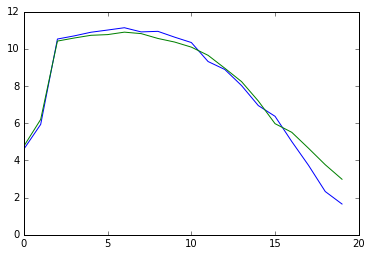

In [224]:
plt.plot(loss_k)
plt.plot(loss_k_new)
# plt.plot(loss_2_k)

In [208]:
# plot_utils.binned_plot(comb_profit_n, calculate_profit(test))

# plot_utils.binned_plot(profit_n.clip(None, 5000), calculate_profit(test))

# amount_n = amount_model.predict(amount_test_pool)


# plot_utils.binned_plot(contacts_n, calculate_profit(test))

In [209]:
# plot_utils.binned_plot(amount_n.clip(None, 5000), calculate_profit(test))

In [210]:
# plot_utils.binned_plot(comb_profit_n.clip(None, 5000), calculate_profit(test))

In [211]:
loss_k.max()

11.133121

In [212]:
loss_2_k.max()

8.57812035

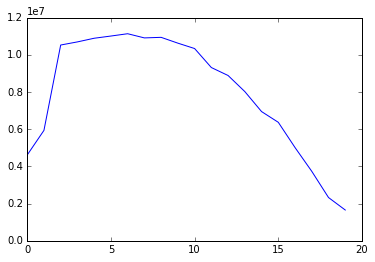

In [89]:
plt.plot(loss_k)

In [81]:
calculate_profit(test)[(comb_profit_n > 0).astype(bool)].mean()

15144.938064046579

In [ ]:
import matplotlib.pyplot as plt
plt.hist(model.predict(val_pool), bins=31);

In [ ]:
for threshold in np.arange(-3, -1, 0.1):
    pred_val = model.predict(val_pool) > threshold
    bs_prof_val = val['profit'].mean()

    model_prof_val = calculate_profit(val)[pred_val.astype(bool)].sum()
    model_prof_val = model_prof_val / len(pred_val)

    print(f'VAL {threshold} | Baseline profit: {bs_prof_val:.2f}, model profit: {model_prof_val:.2f}')

# Previous

## Predict sale_amount

## Construct balances

I'll try to get last balance, and then difference from last balance for last few months

In [123]:
balances = pd.read_csv('train_data/balance.csv')

In [129]:
aum['product_code'].unique()

array(['Current accounts', 'Broker', 'Time account', 'UK', 'NSJ', 'ILI'],
      dtype=object)

In [126]:
balances['prod_cat_name'].unique()

array(['CURRENT ACCOUNTS', 'DEPOSITS', 'Cash on demand',
       'URGENT DEPOSITS BIN', 'SALARY CARDS', 'KN', 'DEBIT CARDS',
       'VIP DEBIT CARDS', 'CASH CREDITS (X-SALE)', 'CREDITS IN CASH OR',
       'LENDING SALARY CLIENTS', 'LOANS FOR EMPLOYEES', nan,
       'CREDIT CARDS', 'VIP CREDIT CARDS', 'PREAD MAP', 'TECHNICAL CARDS',
       'MORTGAGE', 'OTHER MORTGAGE', 'CAR LOANS'], dtype=object)

In [107]:
# Sum up across all accounts
account_sums = balances.groupby(['client_id', 'month_end_dt'])[['avg_bal_sum_rur', 'max_bal_sum_rur', 'min_bal_sum_rur']].sum()

# Get average range (max - min) for all clients
account_sums['range'] = account_sums['max_bal_sum_rur'] - account_sums['min_bal_sum_rur']
avg_range = account_sums['range'].mean(level='client_id', skipna=True)

# Get the average amount in the last month
last_month_avg = account_sums.iloc[account_sums.index.get_level_values('month_end_dt') == '2019-08-31']
last_month_avg = last_month_avg['avg_bal_sum_rur']
last_month_avg.index = last_month_avg.index.droplevel('month_end_dt')

# Get differences from the average in the last month
account_sums['diff_last_month'] = account_sums['avg_bal_sum_rur'] - last_month_avg
diffs = account_sums['diff_last_month'].reset_index().query('month_end_dt != "2019-08-31"')
diffs = diffs.pivot(index='client_id', columns='month_end_dt')

# Put together all balance features
diffs.columns = [f'balance_diff_{c[1]}' for c in diffs.columns]
balance_ft = diffs
balance_ft['avg_range'] = avg_range
balance_ft['last_month_avg'] = last_month_avg

In [108]:
balance_ft.describe()

,balance_diff_2018-09-30,balance_diff_2018-10-31,balance_diff_2018-11-30,balance_diff_2018-12-31,balance_diff_2019-01-31,balance_diff_2019-02-28,balance_diff_2019-03-31,balance_diff_2019-04-30,balance_diff_2019-05-31,balance_diff_2019-06-30,balance_diff_2019-07-31,avg_range,last_month_avg
count,16455.000000,16710.000000,17056.000000,17412.000000,17633.000000,17942.000000,18271.000000,18423.000000,18582.000000,18605.000000,18618.000000,18619.000000,18619.000000
mean,87.988210,51.673190,46.710483,33.441822,17.955481,10.769981,4.449948,8.166042,5.379130,6.465090,4.418520,52.000720,-90.814759
std,1884.751453,1181.022633,1157.721772,950.131726,553.243603,547.045252,498.944701,476.696726,352.540639,324.753785,262.595122,172.862765,934.295467
min,-38052.000000,-25178.000000,-24428.000000,-23909.000000,-23319.000000,-22554.000000,-21500.000000,-21311.000000,-21300.000000,-21454.000000,-20211.000000,0.000000,-31173.000000
25%,-5.000000,-7.000000,-8.000000,-8.000000,-10.000000,-11.000000,-13.000000,-10.000000,-8.000000,-5.000000,-2.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.833333,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.833333,7.000000
max,108444.000000,77117.000000,77565.000000,76899.000000,11144.000000,13059.000000,12013.000000,22115.000000,11144.000000,11144.000000,5795.000000,7792.083333,38052.000000


## Construct AUM

Same as with balances, but now for assets under managament

In [127]:
aum = pd.read_csv('train_data/aum.csv')

In [110]:
# Sum up across all accounts
aum_sums = aum.groupby(['client_id', 'month_end_dt'])[['balance_rur_amt']].sum()

# Get STD for last few months for client
aum_std = aum_sums.std(level='client_id', skipna=True)

# Get the average amount in the last month
last_month_aum = aum_sums.iloc[aum_sums.index.get_level_values('month_end_dt') == '2019-08-31']
last_month_aum = last_month_aum['balance_rur_amt']
last_month_aum.index = last_month_aum.index.droplevel('month_end_dt')

# Get differences from the average in the last month
aum_sums['diff_last_month'] = aum_sums['balance_rur_amt'] - last_month_aum
diffs = aum_sums['diff_last_month'].reset_index().query('month_end_dt != "2019-08-31"')
diffs = diffs.pivot(index='client_id', columns='month_end_dt')

# Put together all balance features
diffs.columns = [f'aum_diff_{c[1]}' for c in diffs.columns]
aum_ft = diffs
aum_ft['aum_std'] = aum_std
aum_ft['aum_last_month'] = last_month_aum

In [111]:
aum_ft.describe()

,aum_diff_2018-11-30,aum_diff_2018-12-31,aum_diff_2019-01-31,aum_diff_2019-02-28,aum_diff_2019-03-31,aum_diff_2019-04-30,aum_diff_2019-05-31,aum_diff_2019-06-30,aum_diff_2019-07-31,aum_std,aum_last_month
count,8.608000e+03,9.813000e+03,9.955000e+03,1.028500e+04,1.064800e+04,1.092600e+04,1.109900e+04,1.133700e+04,1.145600e+04,1.233600e+04,1.155000e+04
mean,-5.001248e+04,-2.714613e+04,-3.435988e+04,-2.387928e+04,-2.682130e+04,-7.292388e+03,-5.554313e+03,3.399581e+02,3.206510e+03,6.753699e+04,1.689718e+05
std,7.507566e+05,6.796489e+05,6.416814e+05,5.892972e+05,4.643446e+05,3.769064e+05,3.329760e+05,3.086190e+05,2.129571e+05,3.048220e+05,9.854516e+05
min,-4.330515e+07,-4.239884e+07,-3.872596e+07,-2.954090e+07,-2.162469e+07,-2.158606e+07,-2.151494e+07,-2.193740e+07,-7.659409e+06,0.000000e+00,-2.078000e+03
25%,-3.222175e+04,-1.827500e+04,-2.341400e+04,-1.804400e+04,-2.073700e+04,-1.057550e+04,-1.231750e+04,-8.498000e+03,-6.059500e+03,3.975839e+03,4.910000e+02
50%,-6.750000e+02,0.000000e+00,-1.450000e+02,0.000000e+00,-2.040000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.461534e+04,1.172700e+04
75%,7.150000e+03,1.319900e+04,3.943000e+03,7.215000e+03,2.927000e+03,1.339375e+04,8.011000e+03,1.158000e+04,8.908000e+03,4.718967e+04,6.347625e+04
max,7.367170e+06,7.980098e+06,8.014740e+06,1.427104e+07,1.026630e+07,1.093164e+07,7.523952e+06,4.848174e+06,1.108082e+07,1.942198e+07,6.464412e+07


In [116]:
aum_ft.shape

(12535, 11)

In [120]:
funnel.shape

(21498, 18)

In [119]:
(funnel.profit > 0).sum()

3311

In [121]:
(funnel.profit < 0).sum()

18187

In [122]:
aum.shape

(117392, 4)

## Construct client dataset

In [228]:
client = pd.read_csv('train_data/client.csv')

# Take out citizenship and job_type, they are useless
client_ft = client.set_index('client_id')[['gender', 'age', 'region', 'city', 'education']]

# Filter out cities and region to only those above 200, make them categorical (not numerical)
region_counts = client_ft['region'].value_counts(dropna=False)
top_regions = region_counts[region_counts > 200].index

city_counts = client_ft['city'].value_counts(dropna=False)
top_cities = city_counts[city_counts > 200].index

client_ft.loc[~ client_ft['city'].isin(top_cities), 'city'] = None
client_ft.loc[~ client_ft['region'].isin(top_regions), 'region'] = None

client_ft['city'] = client_ft['city'].astype('str')
client_ft['region'] = client_ft['region'].astype('str')

client_ft[['gender', 'education']] = client_ft[['gender', 'education']].fillna('nan')

In [230]:
client_ft.describe(include='all')

,gender,age,region,city,education
count,21498,21495.000000,21498,21498,21498
unique,3,NaN,29,17,8
top,F,NaN,nan,nan,nan
freq,11116,NaN,4461,13862,12218
mean,NaN,43.097139,NaN,NaN,NaN
std,NaN,10.798968,NaN,NaN,NaN
min,NaN,21.000000,NaN,NaN,NaN
25%,NaN,34.000000,NaN,NaN,NaN
50%,NaN,42.000000,NaN,NaN,NaN
75%,NaN,52.000000,NaN,NaN,NaN


## Construct final dataset

In [77]:
LABEL_COLS = ['sale_flg', 'sale_amount', 'contacts', 'profit', 'profitable']
CAT_FEATURES = ['gender', 'region', 'city', 'education']
# CAT_FEATURES = []

labels_all = funnel.set_index('client_id')[LABEL_COLS]v
full_data = pd.concat([
    funnel.set_index('client_id')[col_list],
    labels_all,
#     balance_ft,
#     aum_ft,
#     client_ft
], axis=1)

## Split into train, val, test

In [79]:
train, val, test = train_val_test_split(full_data, [0.8, 0.1, 0.1])

train_pool = Pool(
    data = train.drop(LABEL_COLS, axis=1),
    label = train['profit'],
    cat_features=CAT_FEATURES
)

val_pool = Pool(
    data = val.drop(LABEL_COLS, axis=1), 
    label = val['profit'],
    cat_features=CAT_FEATURES
)

test_pool = Pool(data = test.drop(LABEL_COLS, axis=1), cat_features=CAT_FEATURES)

print(val.profit.mean())
print(test.profit.mean())
print(train.profit.mean())

3177.788046511628
2133.9287674418606
2568.7711797883476


## Construct model

In [82]:
model = CatBoostRegressor(
    iterations=1500,
    depth=10,
    loss_function='RMSE',
    use_best_model=True,
)

## Run training

In [83]:
model.fit(train_pool, verbose=100, eval_set=val_pool)

Learning rate set to 0.061276
0:	learn: 23864.0116302	test: 25635.1074146	best: 25635.1074146 (0)	total: 68.7ms	remaining: 1m 43s
100:	learn: 18450.3982870	test: 23271.2939015	best: 23222.7743951 (69)	total: 1.27s	remaining: 17.7s
200:	learn: 16753.4024101	test: 23271.7210726	best: 23222.7743951 (69)	total: 2.38s	remaining: 15.4s
300:	learn: 15592.6078087	test: 23258.4764418	best: 23222.7743951 (69)	total: 3.44s	remaining: 13.7s
400:	learn: 14585.3967141	test: 23310.7740568	best: 23222.7743951 (69)	total: 4.53s	remaining: 12.4s
500:	learn: 13733.3520248	test: 23396.3475657	best: 23222.7743951 (69)	total: 5.81s	remaining: 11.6s
600:	learn: 13034.1410119	test: 23472.5128447	best: 23222.7743951 (69)	total: 6.84s	remaining: 10.2s
700:	learn: 12415.4986253	test: 23565.8671259	best: 23222.7743951 (69)	total: 7.86s	remaining: 8.96s
800:	learn: 11838.6546743	test: 23643.1241998	best: 23222.7743951 (69)	total: 8.89s	remaining: 7.76s
900:	learn: 11253.1939427	test: 23709.9317819	best: 23222.7743

## Evaluate profitability of solution on val

In [87]:
pred_val = model.predict(val_pool) > 0
bs_prof_val = val['profit'].mean()

model_prof_val = calculate_profit(val)[pred_val.astype(bool)].sum()
model_prof_val = model_prof_val / len(pred_val)

print(f'VAL | Baseline profit: {bs_prof_val:.2f}, model profit: {model_prof_val:.2f}')

VAL | Baseline profit: 3177.79, model profit: 4884.83


## Evaluate profitability of solution on test

In [88]:
pred_test = model.predict(test_pool) > 0
bs_prof_test = test['profit'].mean()

model_prof_test = calculate_profit(test)[pred_test.astype(bool)].sum()
model_prof_test = model_prof_test / len(pred_test)

print(f'TEST | Baseline profit: {bs_prof_test:.2f}, model profit: {model_prof_test:.2f}')

TEST | Baseline profit: 2133.93, model profit: 3930.22


## Notes

1. Using just balance  or features, I get below baseline
2. Using balance + client features, I get 3074 on test,  3345.24 on val
3. Using balance + aum + client fts, I get 2944.95 on test, 3607.06 on val

## Train model on FULL data and save it

In [18]:
LABEL_COLS = ['sale_flg', 'sale_amount', 'contacts', 'profit', 'profitable']
CAT_FEATURES = ['gender', 'region', 'city', 'education']

labels_all = funnel.set_index('client_id')[LABEL_COLS]
full_data = pd.concat([
    labels_all,
    balance_ft,
    aum_ft,
    client_ft
], axis=1)

data_pool = Pool(
    data = full_data.drop(LABEL_COLS, axis=1),
    label = full_data['profitable'],
    cat_features=CAT_FEATURES
)

model.fit(data_pool, verbose=100)
model.save_model('models/tadej_model.cbm', 'cbm')

Learning rate set to 0.038183
0:	learn: 0.6218106	total: 78.6ms	remaining: 1m 18s
100:	learn: 0.2142772	total: 7.78s	remaining: 1m 9s
200:	learn: 0.1840746	total: 15.4s	remaining: 1m 1s
300:	learn: 0.1587955	total: 23.2s	remaining: 53.9s
400:	learn: 0.1379047	total: 31.2s	remaining: 46.6s
500:	learn: 0.1222910	total: 39.3s	remaining: 39.1s
600:	learn: 0.1090144	total: 47.4s	remaining: 31.5s
700:	learn: 0.0979489	total: 55.4s	remaining: 23.6s
800:	learn: 0.0880003	total: 1m 2s	remaining: 15.5s
900:	learn: 0.0800735	total: 1m 10s	remaining: 7.7s
999:	learn: 0.0727941	total: 1m 19s	remaining: 0us


## Test load, data and produce predictions

In [19]:
# Save data first, as it would be in the build step
LABEL_COLS = ['sale_flg', 'sale_amount', 'contacts', 'profit', 'profitable']
full_data.drop(LABEL_COLS, axis=1).to_pickle('final_version.pickle')

In [20]:
model = CatBoostClassifier().load_model('models/tadej_model.cbm', 'cbm')
data = pd.read_pickle('final_version.pickle')
data_pool = Pool(data = data, cat_features=CAT_FEATURES)

target = model.predict(data_pool)
submission = pd.DataFrame({'client_id': data.index, 'target': target})
submission.to_csv('submission.csv', index=False)

In [21]:
pd.read_csv('submission.csv')

,client_id,target
0,-9221941791080978530,0
1,-9220369594510368140,0
2,-9220236243053692422,1
3,-9220233431709087652,0
4,-9219699286371310531,0
...,...,...
21493,9219024469308275500,0
21494,9219416956046769492,0
21495,9219968212912398941,0
21496,9220335314469087849,0
